In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\cks12\Downloads\PML Project\dataset\raw\CleanDataset.csv")

In [3]:
X=df[['Age','WorkExperience','MonthlyIncome']]

In [4]:
y=df['Attrition']

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [6]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [9]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=ytrain)
    trace = pm.sample(100, tune=100, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 56 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


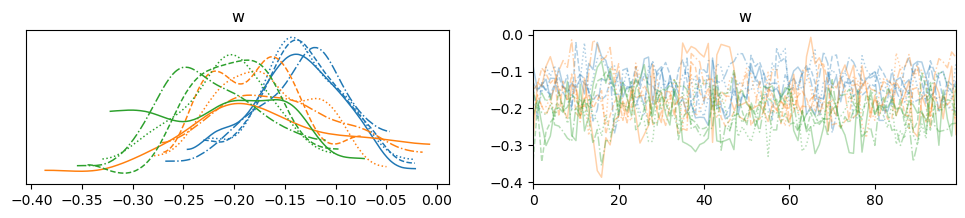

In [10]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [11]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.135,0.045,-0.226,-0.055,0.003,0.002,247.0,237.0,1.00
w[1],-0.166,0.061,-0.279,-0.050,0.006,0.004,129.0,59.0,1.06
w[2],-0.210,0.053,-0.301,-0.101,0.005,0.003,131.0,205.0,1.04


In [12]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [13]:
preds

array([0, 0, 1, ..., 1, 1, 1])

In [14]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 477
Value: 1, Count: 818


In [7]:
import pymc as pm
import numpy as np

with pm.Model():
    w = pm.Normal("w", mu=0, sigma=1, shape=Xtrain_scaled.shape[1])
    logits = pm.math.dot(Xtrain_scaled, w)
    y_obs = pm.Bernoulli("ytest", logit_p=logits, observed=ytrain)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


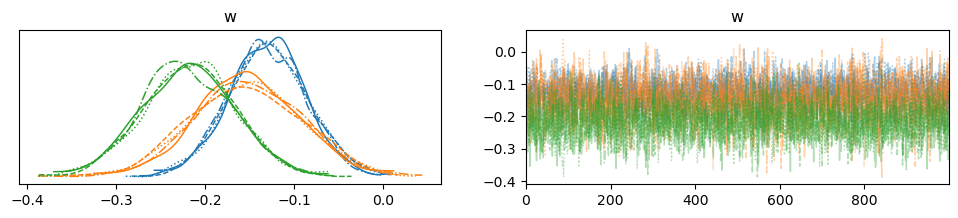

In [8]:
import arviz as az

az.plot_trace(trace)
plt.show()



In [9]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.130,0.044,-0.217,-0.045,0.001,0.001,2327.0,2342.0,1.0
w[1],-0.153,0.061,-0.271,-0.036,0.001,0.001,2037.0,2216.0,1.0
w[2],-0.218,0.052,-0.318,-0.116,0.001,0.001,2183.0,2305.0,1.0


In [10]:
def predict(Xtest, trace):
    from scipy.special import expit
    w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values.T
    logits = Xtest @ w_samples.T
    probs = expit(logits)
    mean_probs = probs.mean(axis=1)
    return mean_probs, (mean_probs > 0.5).astype(int)

# Example usage
probs, preds = predict(Xtest_scaled, trace)



In [11]:
values, counts = np.unique(preds, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 524
Value: 1, Count: 771
